In [1]:
import torch
import torch.nn as nn
import math
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Load data from MNIST

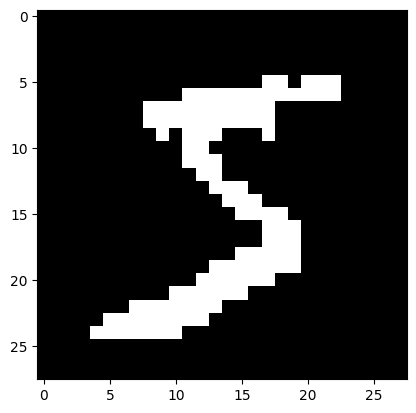

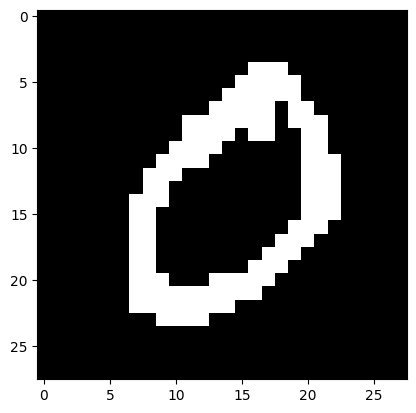

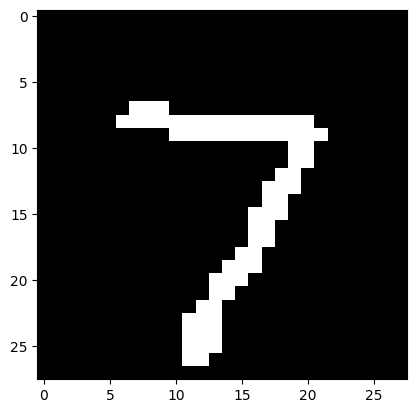

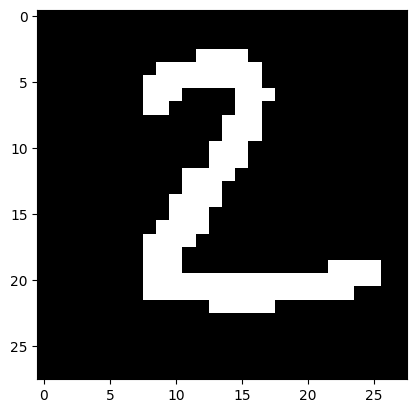

In [156]:
# download the MNIST dataset
train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
# binarize the data
train.data = torch.where(train.data > 128, 1, 0)
test.data = torch.where(test.data > 128, 1, 0)
# plot samples
sample_train = train.data[:2]
sample_test = test.data[:2]
for sample in sample_train:
    plt.figure()
    plt.imshow(sample.numpy(), cmap='gray')
for sample in sample_test:
    plt.figure()
    plt.imshow(sample.numpy(), cmap='gray')

# Define Loss

In [695]:
def elbo(x_hat, x, mu, std):
    bce_loss = nn.BCELoss(reduction='sum')
    kl_divergence = 0.5 * torch.sum(mu ** 2 + std ** 2 - torch.log(std ** 2))
    return bce_loss(x_hat, x) + 5 * kl_divergence

# Define Model

In [697]:
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = 12
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(64, self.latent_dim ),
            nn.Tanh()
        )
        self.std = nn.Sequential(
            nn.Linear(64, self.latent_dim ),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim ,64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, self.input_dim,),
            nn.Sigmoid()
        )
        
    def get_latent_distribution(self, x):
        mu = self.mu(self.encoder(x))
        std = self.std(self.encoder(x))
        return mu, std
    
    def sample_latent_distribution(self, mu, std):
        return std * torch.randn(std.shape[0]).unsqueeze(-1).to(device) + mu
    
    def encode(self, x):
        mu, std = self.get_latent_distribution(x)
        return self.sample_latent_distribution(mu, std), mu, std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        x_hat, mu, std = self.encode(x)
        return self.decode(x_hat), mu, std
    
    def generate(self):
        z = self.sample_latent_distribution(torch.zeros(self.latent_dim ).to(device), torch.ones
        (self.latent_dim).to(device))
        size = int(math.sqrt(self.input_dim))
        return self.decode(z).reshape(z.shape[0], size, size)
    

# Training Loop

In [698]:
vae = VAE(28**2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train.data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test.data, batch_size=100, shuffle=True)

epochs = 15

for epoch in range(epochs):
    epoch_loss = 0
    for batch_idx, x in enumerate(train_loader):
        optimizer.zero_grad()
        x = torch.flatten(x.float(), start_dim=1).to(device)
        x_hat, mu, std = vae(x)
        loss = elbo(x_hat, x, mu, std)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print('Epoch: {}, Loss: {}'.format(epoch + 1, epoch_loss / len(train_loader)))

    




Epoch: 1, Loss: 5194.737702734375
Epoch: 2, Loss: 3753.293591015625
Epoch: 3, Loss: 3470.616396614583
Epoch: 4, Loss: 3324.9196298177085
Epoch: 5, Loss: 3230.832218359375
Epoch: 6, Loss: 3166.2898897135415
Epoch: 7, Loss: 3114.7548666666667
Epoch: 8, Loss: 3074.804042447917
Epoch: 9, Loss: 3040.181546875
Epoch: 10, Loss: 3013.182621875
Epoch: 11, Loss: 2988.044172005208
Epoch: 12, Loss: 2966.87210546875
Epoch: 13, Loss: 2947.650641796875
Epoch: 14, Loss: 2929.304574869792
Epoch: 15, Loss: 2914.27051015625


# Decode Test Data

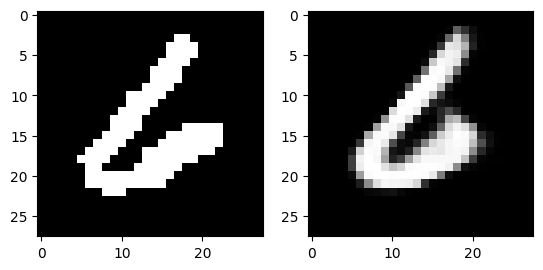

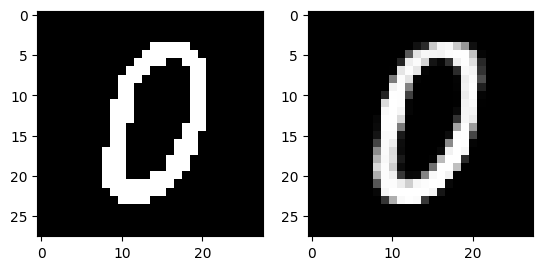

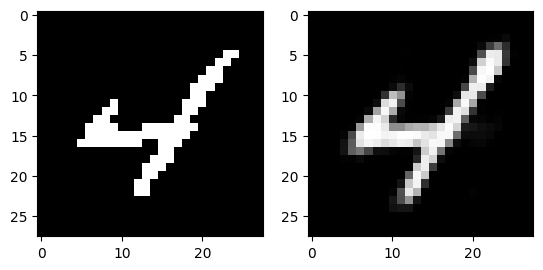

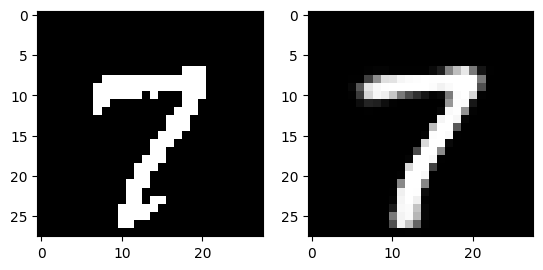

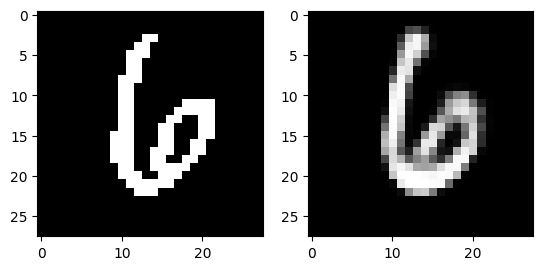

In [699]:
i = 0
limit = 5
for batch_idx, x in enumerate(test_loader):
    if i < limit:
        fig = plt.figure()
        x = torch.flatten(x.float(), start_dim=1).to(device)
        x_hat, _, _ = vae(x)
        size = int(math.sqrt(vae.input_dim))
        
        fig.add_subplot(1, 2, 1)
        plt.imshow(x[0].reshape(size, size).detach().cpu(), cmap='gray')
      
        fig.add_subplot(1, 2, 2)
        plt.imshow(x_hat[0].reshape(size, size).detach().cpu(), cmap='gray')
        
    i += 1
    

# Generate New Digits

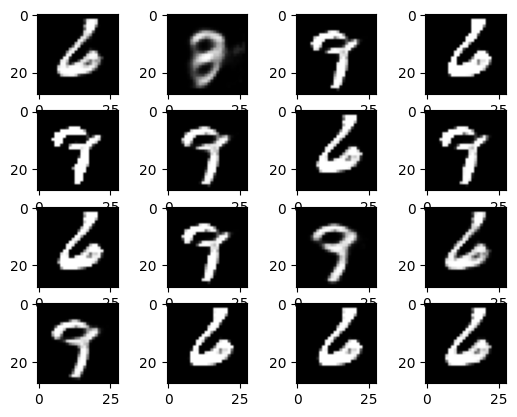

In [702]:
import math
num_images = 16
num_columns = 4
f, axs = plt.subplots(4, num_images // num_columns)
axs = axs.flatten()
for i, ax in enumerate(axs):
    size = int(math.sqrt(vae.input_dim))
    ax.imshow(vae.generate().detach().cpu()[0], cmap='gray')
plt.show()